### Import Packages

In [64]:
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
import os
import sys
import copy
import pandas as pd

### Generating the 2-layer network from Twitter data

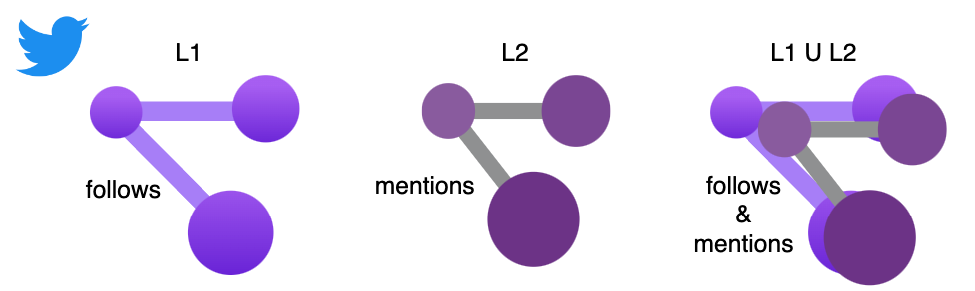

### Load network

In [65]:
#The stochastic matrix of G's adjacency
def weighted(G, make_self = False):
    A = nx.adjacency_matrix(G).todense()
    con = 0
    for i in range(len(G.nodes())): 
        if (np.sum(A[i,:])==0):
            A[i,i] = 1
            con+=1
    return torch.from_numpy((A.T*1/A.sum(axis = 1).T).T)

#Graph from edge list file
def read_edge_list(filename, n = 3409):
    G = nx.Graph()
    for i in range(n): 
        G.add_node(i)
    with open(filename) as file:
        for line in file:
            u = int(line.split(' ')[0])
            v = int(line.split(' ')[1][0:-1])
            G.add_edge(u,v)
    return G

#Loading Twitter data
def load_real_data(n):
    Ws = []
    G1 = read_edge_list(f'./Twitter/G_v_scc.edgelist', n)
    G2 = read_edge_list(f'./Twitter/G_vax_scc.edgelist', n)
    Ws.append(weighted(G1))
    Ws.append(weighted(G2))
    A1 = nx.adjacency_matrix(G1).todense()
    A2 = nx.adjacency_matrix(G2).todense()
    for i in range(n): 
        if np.sum(A1[i,:])==0: A1[i,i] = 1
    for i in range(n): 
        if np.sum(A2[i,:])==0: A2[i,i] = 1
    Ws.append((torch.from_numpy(((A1+A2).T*1/(A1+A2).sum(axis = 1).T).T)))
    return Ws

### Predictions
$$x_u(t)=\alpha_us_u+\sum\limits_{i\in[t_{\min},t_{\max}]}\beta_u(i)x_u(t-i)+\left(1-\alpha_u-\sum\limits_{i\in[t_{\min},t_{\max}]}\beta_u(i)\right)\sum\limits_{\ell\in[L]}\lambda_{\ell}\mathbf{w}^{\top}_{l,u}\mathbf{x}(t-1)$$

In [66]:
#Given initial opinions (s), the resistance parameters (alphas),
#the layer weights (lambdas), the weighted adjacency matrices (W) and 
#opinions in [t-window_size] (xts), function returns opinions at t+1 (x(t+1)).
def predict(s, alphabetas, lambdas, window_size, W, xts):
    n = len(s)
    xt_plus_1 = alphabetas[:,0].reshape(n,1)*s.reshape(n,1)
    if window_size>0:
        xt_plus_1 += torch.diag(alphabetas[:,1:].reshape(n, window_size)@xts.T).reshape(n,1)
    for u in range(n): 
        for l in range(len(lambdas)):
            xt_plus_1[u,0] += float((1-torch.sum(alphabetas[u,:]))*lambdas[l]*(W[l][u,:].reshape(1,n)@xts[:,-1]))
    return xt_plus_1

### Projected Gradient Descent  (PGD)

In [67]:
import numpy as np
from numpy import linalg as LA
import torch
import torch.nn as nn
import cvxpy as cp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class TensorSolver:
    #Init Function
    def __init__(self, b, window_size, Ws, x, y, loss_function = torch.nn.L1Loss()):
        #number of nodes
        self.n = len(Ws[0])
        #number of layers
        self.L =  len(Ws)
        #number of timestamps
        self.T = len(x)
        #window_size
        self.window_size = window_size
        #Unknown variables: 
        # first column are biased-lambdas 
        # second window_size are memory-lambdas
        self.alphabetas = torch.from_numpy(np.ones((self.n, self.window_size+1))/(self.window_size+1+1)).to(device)
        self.alphabetas[:,0] = 0
        self.alphabetas[:,1:] = 1
        self.alphabetas.requires_grad_(True)
        # lambdas are layer-lambdas
        self.lambdas = torch.from_numpy(np.ones((self.L, 1))/self.L).to(device)
        self.lambdas.requires_grad_(True)
        #Loss function
        self.criterion = loss_function
        #biases
        self.b = b
        #stochastic matrices
        self.Ws = Ws
        #input
        self.x = x
        #output
        self.y = y
        

    #Predict Function 
    def pred(self, t = 0):
        prediction = self.alphabetas[:,0].reshape(-1,1)*self.b
        if window_size>0:
            prediction += torch.diag(self.alphabetas[:,1:]@self.x[t].T).reshape(-1,1)
        for l in range(self.L): 
            prediction += self.lambdas[l,0]*(self.Ws[l]*((1-torch.sum(self.alphabetas, axis=1).reshape(-1,1))@torch.ones((1,self.n)).double()))@(self.x[t][:,-1].reshape(-1,1))
        return prediction    


    #Loss Function
    def loss(self, T=None):
        if T is not None: toprint = True
        if T is None: T = self.T
        squared_all = 0
        for t in range(T):
            squared_all = squared_all + (1/self.T)*self.criterion(self.pred(t), self.y[t])
        return squared_all
    
    
    #L1
    def lossL1(self, T=None):
        if T is not None: toprint = True
        if T is None: T = self.T
        squared_all = 0
        for t in range(T):
            squared_all = squared_all + (1/self.T)*torch.nn.L1Loss()(self.pred(t), self.y[t])
        return squared_all
    
    
    #Gradient Descent
    def gradient(self, lr = 1):
        if self.alphabetas.requires_grad and self.lambdas.requires_grad:
            self.loss().backward()
            self.alphabetas.data  -= lr*self.alphabetas.grad.data
            self.lambdas.data  -= lr*self.lambdas.grad.data
            self.projection_new()


    #Projection to feasible solution
    def projection_new(self):
        self.lambdas.grad.zero_()
        Lambdas = self.lambdas.data
        Lnew = cp.Variable(Lambdas.shape)
        prob = cp.Problem(cp.Minimize(cp.sum_squares(Lambdas - Lnew)),
                          [Lnew >= 0,
                           Lnew <= 1,
                           cp.sum(Lnew[-self.L:])==1])
        prob.solve()
        self.lambdas = torch.tensor(Lnew.value)
        self.lambdas.requires_grad_()    
        
        
        self.alphabetas.grad.zero_()
        Alphabetas = self.alphabetas.data
        Alphabetasnew = cp.Variable(Alphabetas.shape)
        prob = cp.Problem(cp.Minimize(cp.sum_squares(Alphabetas - Alphabetasnew)),
                          [Alphabetasnew >= 0,
                           Alphabetasnew <= 1,
                           cp.sum(Alphabetasnew, axis=1)<=np.ones(len(Alphabetas))])
        prob.solve()
        self.alphabetas = torch.tensor(Alphabetasnew.value)
        self.alphabetas.requires_grad_()  
        
    
    
    #Training Phase
    def training(self, num_epochs = 500, lrdiv = 5, printall = True, printL1 = True): 
        if printall: 
            if printL1: print('Initial: ',self.lossL1().item())
            else: print('Initial: ',self.loss().item())
        training_loss = []
        for epoch in range(num_epochs):
            lr = lrdiv#self.n/lrdiv
            self.gradient(lr=lr) 
            lossval = 0
            if printL1: lossval = self.lossL1().item()
            else: lossval = self.loss().item()
            training_loss.append(lossval)
            if printall:
                if epoch % 1 == 0:
                    print(f"Epoch: {epoch}, L1 loss {lossval:.8}")
                    print(f"Epoch: {epoch}, L2 loss {self.loss().item():.8}")
                    print()
        return training_loss

    
    #Testing Phase
    def test(self, Ws, x, y):
        #number of nodes
        self.n = len(Ws[0])
        #number of layers
        self.L =  len(Ws)
        #number of timestamps
        self.T = len(Ws)
        #Loss function
        #self.criterion = torch.nn.MSELoss()
        self.criterion = torch.nn.L1Loss()
        #input
        self.x = x
        #output
        self.y = y
        return self.loss(T=len(y)) 



### Run the experiments

In [68]:
def split_train_and_test_data(n, ops_all, T_train, T_test):
    x_train = [ops_all[i].reshape(n, 1) for i in range(T_train)]
    y_train = [ops_all[i].reshape(n, 1) for i in range(1,T_train+1)]
    x_test = [ops_all[i].reshape(n, 1) for i in range(T_train, T_train+T_test)]
    y_test = [ops_all[i].reshape(n, 1) for i in range(T_train+1, T_train+T_test+1)]
    return x_train, y_train, x_test, y_test 

def transform_x(x, s_, window_size=1):
    if window_size <=1: return x
    colnums = max(1,window_size)
    x_new = list()
    X = torch.zeros((n, colnums))
    for w in range(colnums):
        X[:,w] = s_
    x_new.append(X)
    for t in range(T): 
        pred = x[t]
        x_new.append(torch.zeros((n, colnums)))
        x_new[-1][:,:-1] = x_new[-2][:,1:]
        x_new[-1][:,-1] = pred.reshape(-1)
    return x_new


def run_the_experiments(n, algname, window_size=1):
    _start = 100
    _end = 200#1000
    _step = 10#100
    T_train = 5#90
    T_test = 5#10

    
    results = {}
    results['train_loss'] = []
    results['train_epoch'] = []
    results['test_loss'] = []
    results['alphabetas'] = []
    results['lambdas'] = []
    for start_point in range(_start, _end, _step):
        Ws = load_real_data(n)
        ops_all = np.array(pd.read_csv(f'./Twitter/vax_ops.txt', sep=' ', header=None))/10
        #print(ops_all.shape)
        s_ = torch.from_numpy(ops_all[:,0].reshape(n,1))
        x_train, y_train, x_test, y_test  = split_train_and_test_data(n, 
                                             torch.from_numpy(ops_all[:,start_point:start_point+T_train+T_test+1].T), 
                                             T_train, T_test)
        x_train = transform_x(x_train, s_, window_size)
        x_test = transform_x(x_test, s_, window_size)
        
        Ws_ = copy.deepcopy(Ws)
        if algname == 'multi': Ws_ = [Ws[0], Ws[1]]
        elif algname == 'l1': Ws_ = [Ws[0], Ws[0]]
        elif algname == 'l2': Ws_ = [Ws[1], Ws[1]]
        elif algname == 'lboth': Ws_ = [Ws[2], Ws[2]]
        else: return
            
        solver  = TensorSolver(s_, window_size, Ws_, x_train, y_train)
        train_loss = solver.training(num_epochs = 500, lrdiv = 0.1, printall = False, printL1 = True) #change False to True for printing loss
        test_loss = []
        for t in range(T_test):
            test_loss.append(torch.nn.L1Loss()(predict(s_, 
                                                       solver.alphabetas.detach(),
                                                       solver.lambdas.detach().reshape(-1),
                                                       window_size,
                                                       Ws_, 
                                                       x_test[t]).reshape(n,1), y_test[t].reshape(n,1)).numpy())
        print(f'Algorithm {algname}')
        print('Test Loss: ', test_loss)
        results['train_epoch'].append(train_loss)
        results['test_loss'].append(np.mean(test_loss))
        results['alphabetas'].append(solver.alphabetas.detach().numpy())
        results['lambdas'].append(solver.lambdas.detach().numpy())
        
        train_loss = []
        for t in range(T_train):
            train_loss.append(torch.nn.L1Loss()(predict(s_, 
                                                       solver.alphabetas.detach(),
                                                       solver.lambdas.detach().reshape(-1),
                                                       window_size,
                                                       Ws_, 
                                                       x_train[t]).reshape(n,1), y_train[t].reshape(n,1)).numpy())
        results['train_loss'].append(np.mean(train_loss))
    return results


n = 430
window_size = 1
alg_results = {}
for algname in ['multi', 'l1', 'l2', 'lboth']: 
    alg_results[algname] = run_the_experiments(n, algname, window_size)

Algorithm multi
Test Loss:  [array(0.01602782), array(0.0162486), array(0.015017), array(0.02037918), array(0.02308978)]
Algorithm multi
Test Loss:  [array(0.0211344), array(0.02189606), array(0.01470508), array(0.01813998), array(0.0203458)]
Algorithm multi
Test Loss:  [array(0.01878516), array(0.01428443), array(0.00913062), array(0.01584652), array(0.01726605)]
Algorithm multi
Test Loss:  [array(0.02097766), array(0.01243263), array(0.01835039), array(0.01861771), array(0.01633575)]
Algorithm multi
Test Loss:  [array(0.01585838), array(0.01469184), array(0.0095034), array(0.00987455), array(0.01380503)]
Algorithm multi
Test Loss:  [array(0.00919613), array(0.01182717), array(0.01042043), array(0.01490183), array(0.01029443)]
Algorithm multi
Test Loss:  [array(0.01387352), array(0.01086112), array(0.01472362), array(0.01171316), array(0.00961694)]
Algorithm multi
Test Loss:  [array(0.01096653), array(0.01305535), array(0.01878892), array(0.0126565), array(0.0188685)]
Algorithm multi


### Average results

In [69]:
for algname in alg_results:
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['train_epoch_mean'] = np.mean(alg_results[algname]['train_epoch'], axis = 0)
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    alg_results[algname]['alphabetas_mean'] = np.mean(alg_results[algname]['alphabetas'], axis = 0)
    alg_results[algname]['lambdas_mean'] = np.mean(alg_results[algname]['lambdas'], axis = 0)
    
    alg_results[algname]['train_loss_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['train_epoch_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_std'] = np.std(alg_results[algname]['test_loss'], axis = 0)
    alg_results[algname]['alphabetas_std'] = np.std(alg_results[algname]['alphabetas'], axis = 0)
    alg_results[algname]['lambdas_std'] = np.std(alg_results[algname]['lambdas'], axis = 0)

### Plot average train loss vs epochs

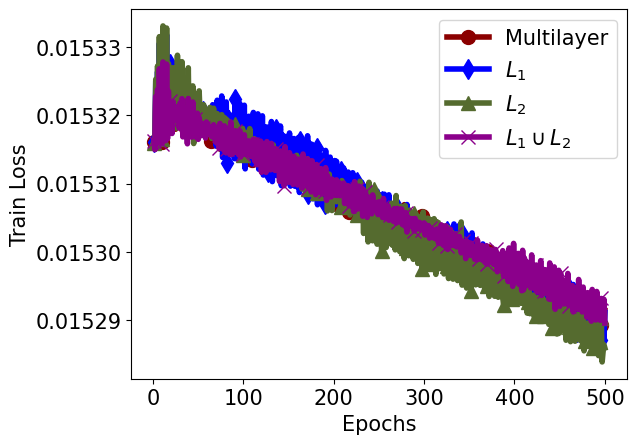

In [70]:
def plot_train_loss(alg_results):
    fig, axes = plt.subplots(1)
    m = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta']
    names_plot = ['Multilayer', r'$L_1$', r'$L_2$', r'$L_1\cup L_2$']
    markers = ["o", "d", "^", "x"]
    ax1 = axes
    j = 0
    for algname in alg_results:
        ax1.plot(range(1, len(alg_results[algname]['train_epoch_mean']) + 1), 
                 alg_results[algname]['train_epoch_mean'], 
                 color = m[j], label = names_plot[j],linewidth=4.0,
                 marker = markers[j], markevery=9, markersize=10)
        j += 1
    plt.legend(fontsize=15)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Train Loss', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(f'./Figures/train_loss_twitter.png', bbox_inches='tight', dpi=1000)
    plt.show()
    
plot_train_loss(alg_results)

### Plot average test loss 

multi -> 0.015291373672460135
l1 -> 0.015291095792568868
l2 -> 0.015285887261021666
lboth -> 0.015289536155486557


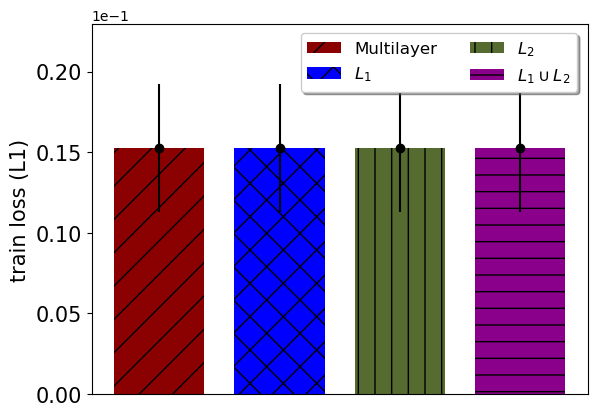

multi -> 0.013589569564182589
l1 -> 0.013607098594612921
l2 -> 0.01358552059837983
lboth -> 0.013588119113481817


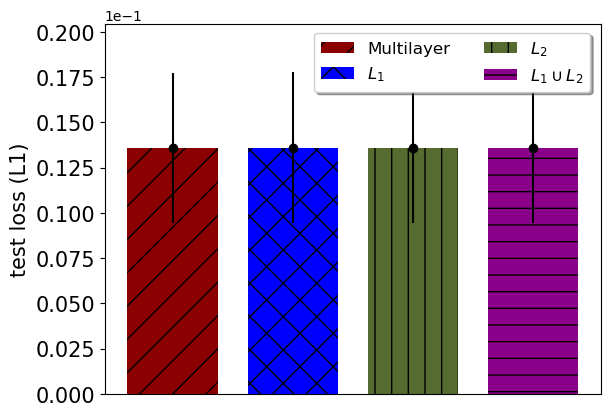

In [71]:
def plot_loss(alg_results, name_ = 'test'):
    fig, axes = plt.subplots()
    names_plot = ['Multilayer', r'$L_1$', r'$L_2$', r'$L_1\cup L_2$', 'GCN', 'ARIMA', 'Naive']
    #d = ['lightcoral', 'cornflowerblue', 'lightgreen', 'pink', '']
    #c = ['indianred', 'royalblue', 'greenyellow', 'hotpink']
    m = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta', 'lightcoral', 'hotpink', 'lightgreen']
    hatches = ['/', 'x', '|', '-', '+', '*', '\\']
    i = 0
    max_ = -1
    for algname in alg_results:
        x = np.arange(1)  # the label locations
        width = 0.15      # the width of the bars
        offset = width * i
        max_ = max(alg_results[algname][f'{name_}_loss_mean'], max_)
        print(f'{algname} -> {alg_results[algname][f"{name_}_loss_mean"]}')
        axes.bar(x + offset, alg_results[algname][f'{name_}_loss_mean'], 3*width/4,
                label=names_plot[i], color = m[i],
                hatch=hatches[i])
        axes.errorbar(x + offset, alg_results[algname][f'{name_}_loss_mean'],
                      alg_results[algname][f'{name_}_loss_std'],
                            fmt="o", color='black')
        i += 1
    plt.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
    plt.ylim(top=max_+0.5*max_)
    plt.ylim(bottom=0)
    plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.7, 1.0),
          ncol=2, fancybox=True, shadow=True)
    plt.ticklabel_format(axis='both', style='sci', scilimits=(-1,-1))
    plt.ylabel(f'{name_} loss (L1)', fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(f'./Figures/test_loss_synthetic.png', bbox_inches='tight', dpi=1000)
    plt.show()
    
plot_loss(alg_results, 'train')
plot_loss(alg_results, 'test')

### Plot distribution of average predicted alphas  

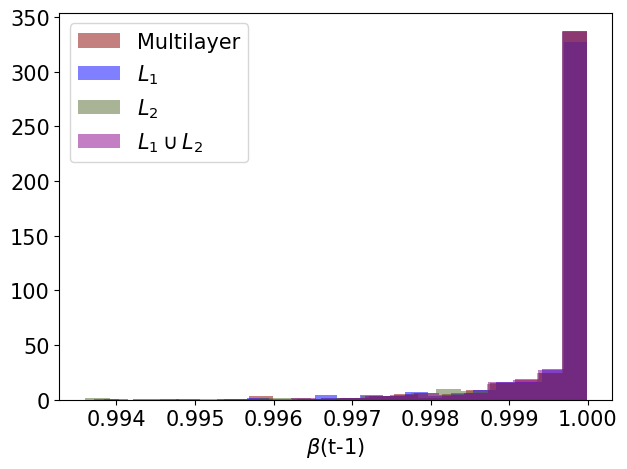

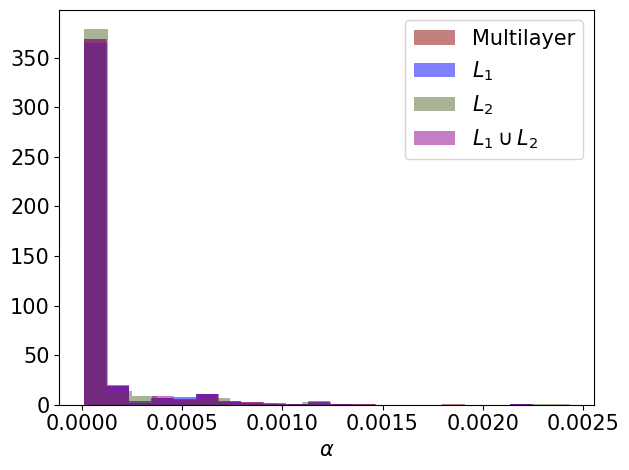

In [72]:
def plot_alphas_distribution(alg_results):
    colors = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta']
    names_plot = ['Multilayer', r'$L_1$', r'$L_2$', r'$L_1\cup L_2$']
    for k in range(window_size, -1, -1):
        i = 0
        for algname in alg_results:
            plt.hist(np.array(alg_results[algname]['alphabetas_mean'][:,k]), bins=20, 
                     color = colors[i] ,label = names_plot[i], alpha = 0.5)
            i += 1
        plt.legend()
        plt.legend(fontsize=15)
        if k == 0:
            plt.xlabel(r'$\alpha$', fontsize=15)
        else: 
            t = k-window_size+1
            plt.xlabel(r'$\beta$'f'(t-{t})', fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.tight_layout()
        plt.savefig(f'./Figures/alpha_distribution_twitter.png', bbox_inches='tight', dpi=1000)
        plt.show()
    
plot_alphas_distribution(alg_results)

### Predicted layer parameters

In [73]:
for algname in alg_results:
    print(f'For {algname} lambdas are: {alg_results[algname]["lambdas_mean"].T[0]}')

For multi lambdas are: [0.49998917 0.50001083]
For l1 lambdas are: [0.5 0.5]
For l2 lambdas are: [0.5 0.5]
For lboth lambdas are: [0.5 0.5]


## GCN
The residual gated graph convolutional operator from the “Residual Gated Graph ConvNets” paper.
\begin{equation}
\mathbf{x}'_i = \mathbf{W}_1 \mathbf{x}_i + \sum_{j \in \mathcal{N}(i)} \eta_{i,j} \odot \mathbf{W}_2 \mathbf{x}_j
\end{equation}
 
where the gate $\eta_{i,j}$
 is defined as

\begin{equation}
\eta_{i,j} = \sigma (\mathbf{W}_3 \mathbf{x}_i + \mathbf{W}_4 \mathbf{x}_j)
\end{equation}

with $\sigma$
 denoting the sigmoid function.

In [75]:
dataset = []
T_train = 5#90
T_test = 5#10
n = 430
_start = 100
_end = 200#1000
_step = 10#100
i=0
k = 0
for start_point in range(_start, _end, _step):
        dataset.append({})
        dataset[k]['W'] = list()
        dataset[k]['s'] = None
        dataset[k]['x'] = list()
        Ws = load_real_data(n)
        ops_all = np.array(pd.read_csv(f'./Twitter/vax_ops.txt', sep=' ', header=None))/10
        s_ = torch.from_numpy(ops_all[:,0].reshape(n,1))
        if dataset[k]['s'] is None: dataset[k]['s'] = s_
        
        for i in range(T_train+T_test+1):
            dataset[k]['x'].append(torch.from_numpy(ops_all[:,start_point:start_point+T_train+T_test+1].T[i].reshape(n, 1)))
        
        Ws = load_real_data(n)
        if len(dataset[k]['W'])==0: dataset[0]['W'] = copy.deepcopy(Ws)
        k+=1

In [76]:
import torch
from torch.nn import Linear
from torch_geometric.nn import ResGatedGraphConv


class GCN(torch.nn.Module):
    def __init__(self, numfeat = -1):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = ResGatedGraphConv(numfeat, 64, bias = True)
        self.conv2 = ResGatedGraphConv(64, 32, bias = True)
        self.conv3 = ResGatedGraphConv(32, 16, bias = True)
        self.classifier = Linear(16, 1, bias=True)
        

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)
        return out, h

In [77]:
n = len(dataset[0]['s'])

x_train = []
y_train = []
x_test = []
y_test = []
edge_index = []

for k in range(len(dataset)):
    x_train.append(torch.zeros((T_train, n, max(1,window_size) + 1)))
    y_train.append(torch.zeros((T_train, n, 1)))
    for i in range(T_train):
        x_train[k][i,:,0] = dataset[k]['s'].reshape(-1)
        x_train[k][i,:,1] = dataset[k]['x'][i].reshape(-1)

        y_train[k][i,:,0] = dataset[k]['x'][i+1].reshape(-1)

    x_test.append(torch.zeros((T_test, n, max(1,window_size) + 1)))
    y_test.append(torch.zeros((T_test, n, 1)))
    for i in range(T_train, T_train+T_test):
        x_test[k][i-T_train,:,0] = dataset[k]['s'].reshape(-1)
        x_test[k][i-T_train,:,1] = dataset[k]['x'][i].reshape(-1)

        y_test[k][i-T_train,:,0] = dataset[k]['x'][i+1].reshape(-1)

    Ws = dataset[0]['W'][2]
    edge_index.append([[],[]])
    for _ in range(1):
        for i in range(Ws.shape[0]):
            for j in range(Ws.shape[0]):
                if Ws[i][j]>0:
                    (edge_index[k][0]).append(int(i))
                    (edge_index[k][1]).append(int(j))
    edge_index[k]=torch.sparse.Tensor(edge_index[k]).to(torch.int64)

In [78]:
def train_my_model(model, x_train, y_train, edge_index, criterion, optimizer):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(x_train, edge_index)  # Perform a single forward pass.
    loss = criterion(out, y_train)  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

def test_my_model(model, x_test, y_test, edge_index, criterion):
    list_of_losses = []
    for k in range(len(x_test)):
        out, h = model(x_test[k,:,:], edge_index)  # Perform a single forward pass.
        loss = criterion(out, y_test[k,:,:])  # Compute the loss solely based on the training nodes.
        list_of_losses.append(loss.detach().numpy())
    return list_of_losses


alg_results['gnn'] = {'train_loss':[]}
alg_results['gnn']['test_loss'] = []
for k in range(len(dataset)):
    model = GCN()
    #criterion = torch.nn.MSELoss()  
    criterion = torch.nn.L1Loss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Initialize the Adam optimizer.

    for epoch in range(100):
        loss, h = train_my_model(model, x_train[k], y_train[k], edge_index[k], criterion, optimizer)
        if epoch%10==0: print(f'Epoch: {epoch}, Train Loss: {loss}')

    train_losses = test_my_model(model, x_train[k], y_train[k], edge_index[k], criterion = torch.nn.L1Loss())
    test_losses = test_my_model(model, x_test[k], y_test[k], edge_index[k], criterion = torch.nn.L1Loss())
    
    alg_results['gnn']['train_loss'].append(np.mean(train_losses))
    alg_results['gnn']['test_loss'].append(np.mean(test_losses))
    
    print(f'Train Loss: {np.mean(train_losses)}')
    print(f'Test Loss: {np.mean(test_losses)}')
    print()

Epoch: 0, Train Loss: 0.27347010374069214
Epoch: 10, Train Loss: 0.17355024814605713
Epoch: 20, Train Loss: 0.11151933670043945
Epoch: 30, Train Loss: 0.07167941331863403
Epoch: 40, Train Loss: 0.052399225533008575
Epoch: 50, Train Loss: 0.04806579276919365
Epoch: 60, Train Loss: 0.04371347650885582
Epoch: 70, Train Loss: 0.053871169686317444
Epoch: 80, Train Loss: 0.042730700224637985
Epoch: 90, Train Loss: 0.04584016650915146
Train Loss: 0.0406169518828392
Test Loss: 0.044633738696575165

Epoch: 0, Train Loss: 0.26069098711013794
Epoch: 10, Train Loss: 0.15803931653499603
Epoch: 20, Train Loss: 0.10340409725904465
Epoch: 30, Train Loss: 0.06439011543989182
Epoch: 40, Train Loss: 0.052959319204092026
Epoch: 50, Train Loss: 0.0546342134475708
Epoch: 60, Train Loss: 0.04676414281129837
Epoch: 70, Train Loss: 0.044126465916633606
Epoch: 80, Train Loss: 0.043195515871047974
Epoch: 90, Train Loss: 0.04812348634004593
Train Loss: 0.04160858318209648
Test Loss: 0.06397511065006256

Epoch: 0,

In [79]:
for algname in ['gnn']:
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['train_loss_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    alg_results[algname]['test_loss_std'] = np.std(alg_results[algname]['test_loss'], axis = 0)

multi -> 0.015291373672460135
l1 -> 0.015291095792568868
l2 -> 0.015285887261021666
lboth -> 0.015289536155486557
gnn -> 0.03944794088602066


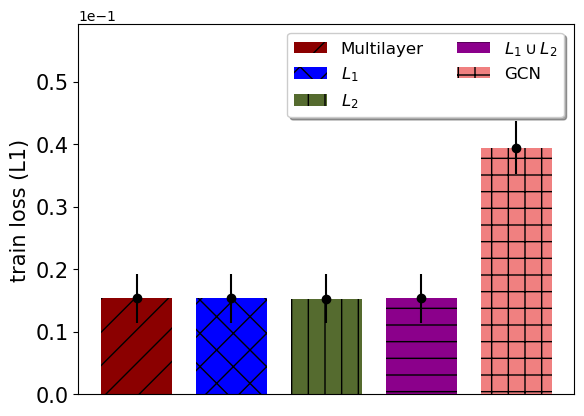

multi -> 0.013589569564182589
l1 -> 0.013607098594612921
l2 -> 0.01358552059837983
lboth -> 0.013588119113481817
gnn -> 0.04048994928598404


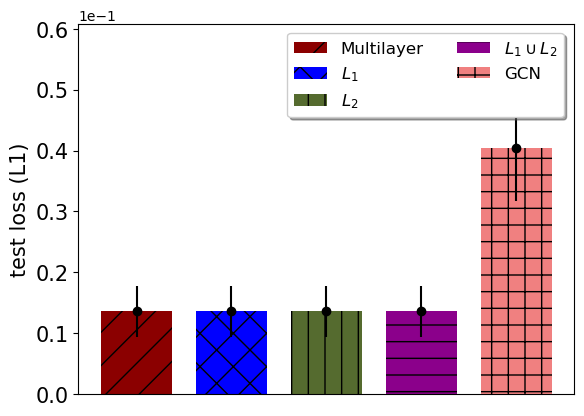

In [80]:
plot_loss(alg_results, 'train')
plot_loss(alg_results, 'test')

## ARIMA

In [81]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
_start = 100
_end = 200#1000
_step = 10#100
alg_results['arima'] = {'train_loss':[]}
alg_results['arima']['test_loss'] = []
for start_pos in range(_start, _end, _step):
    arima_train_loss = np.zeros(T_train)
    arima_test_loss = np.zeros(T_test)
    
    for node in range(n):
        preds = []
        for i in range(T_train):
            warnings.simplefilter("ignore")
            if i==0: preds.append(ops_all[node, start_pos])
            else:
                if i<=1: mod = ARIMA(ops_all[node,start_pos:start_pos+i+1], order=(1, 0, 0))
                else: mod = ARIMA(ops_all[node,start_pos:start_pos+i+1], order=(1, 1, 1))
                mod.initialize_approximate_diffuse()
                model_fit = mod.fit()
                preds.append(model_fit.forecast(1)[0])
        arima_train_loss += np.abs(preds-ops_all[node,start_pos+i+1])
        
        preds = []
        for i in range(T_test):
            warnings.simplefilter("ignore")
            mod = ARIMA(ops_all[node,start_pos:start_pos+T_train+i+1], order=(1, 1, 1))
            model_fit = mod.fit()
            mod.initialize_approximate_diffuse()
            preds.append(model_fit.forecast(1)[0])
        arima_test_loss += np.abs(preds-ops_all[node,start_pos+T_train+i+1])
    
    arima_train_loss = arima_train_loss/n
    alg_results['arima']['train_loss'].append(np.mean(arima_train_loss))
        
    arima_test_loss = arima_test_loss/n
    alg_results['arima']['test_loss'].append(np.mean(arima_test_loss))
    
    print(f'Train Loss: {np.mean(arima_train_loss)}')
    print(f'Test Loss: {np.mean(arima_test_loss)}')
    print()
    
for algname in ['arima']:
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['train_loss_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    alg_results[algname]['test_loss_std'] = np.std(alg_results[algname]['test_loss'], axis = 0)

Train Loss: 0.03717263157592189
Test Loss: 0.04454686340439011

Train Loss: 0.04389635169309124
Test Loss: 0.04217800135962014

Train Loss: 0.04471151990605103
Test Loss: 0.03245289868448791

Train Loss: 0.041373093975801814
Test Loss: 0.04181818804062194

Train Loss: 0.03946602879137197
Test Loss: 0.03143672550480185

Train Loss: 0.028805621891056832
Test Loss: 0.02126440767720277

Train Loss: 0.026082082391370488
Test Loss: 0.020384640478498754

Train Loss: 0.02338842352727795
Test Loss: 0.029074612805181664

Train Loss: 0.021477527160813574
Test Loss: 0.02419786895622441

Train Loss: 0.01745357713611633
Test Loss: 0.008720215215305981



In [82]:
#alg_results['arima'] = {'train_loss':[]}
#alg_results['arima']['test_loss'] = []

'''
alg_results['arima']['train_loss'] = [0.05557088724635333, 0.058962035875622744, 0.061835218361590547,
                                     0.06919860669171299, 0.0681093750302622, 0.07146842678518123,
                                     0.06391428374465878, 0.04597299902719159, 0.0407364267190654,
                                     0.02613641361932643]

alg_results['arima']['test_loss'] = [0.016403098320128397, 0.02111270711913578, 0.024639161955555655, 
                                    0.017942205225516702, 0.014240164575428923, 0.02353571073085292,
                                    0.018390241671847864, 0.013259155711289083, 0.01681322498527932,
                                    0.004687627587264798]
'''

"\nalg_results['arima']['train_loss'] = [0.05557088724635333, 0.058962035875622744, 0.061835218361590547,\n                                     0.06919860669171299, 0.0681093750302622, 0.07146842678518123,\n                                     0.06391428374465878, 0.04597299902719159, 0.0407364267190654,\n                                     0.02613641361932643]\n\nalg_results['arima']['test_loss'] = [0.016403098320128397, 0.02111270711913578, 0.024639161955555655, \n                                    0.017942205225516702, 0.014240164575428923, 0.02353571073085292,\n                                    0.018390241671847864, 0.013259155711289083, 0.01681322498527932,\n                                    0.004687627587264798]\n"

In [83]:
for algname in ['arima']:
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['train_loss_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    alg_results[algname]['test_loss_std'] = np.std(alg_results[algname]['test_loss'], axis = 0)

## NAIVE APPROACH

In [84]:
alg_results['naive'] = {'train_loss':[]}
alg_results['naive']['test_loss'] = []
for start_pos in range(_start, _end, _step):
    naive_train_loss = np.zeros(T_train)
    for node in range(n):
        preds = ops_all[node,start_pos:start_pos+T_train].reshape(-1)
        test_ops = ops_all[node,start_pos+1:start_pos+T_train+1].reshape(-1)
        naive_train_loss += np.abs(preds-test_ops)
    naive_train_loss = naive_train_loss/n
    alg_results['naive']['train_loss'].append(np.mean(naive_train_loss))
    
    
    naive_test_loss = np.zeros(T_test)
    for node in range(n):
        preds = ops_all[node,start_pos+T_train:start_pos+T_train+T_test].reshape(-1)
        test_ops = ops_all[node,start_pos+T_train+1:start_pos+T_train+T_test+1].reshape(-1)
        naive_test_loss += np.abs(preds-test_ops)
    naive_test_loss = naive_test_loss/n
    alg_results['naive']['test_loss'].append(np.mean(naive_test_loss))

    
for algname in ['naive']:
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['train_loss_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    alg_results[algname]['test_loss_std'] = np.std(alg_results[algname]['test_loss'], axis = 0)

In [85]:
#alg_results

In [86]:
#del alg_results['arima']

multi -> 0.015291373672460135
l1 -> 0.015291095792568868
l2 -> 0.015285887261021666
lboth -> 0.015289536155486557
gnn -> 0.03944794088602066
arima -> 0.03238268580488731
naive -> 0.015311377343586646


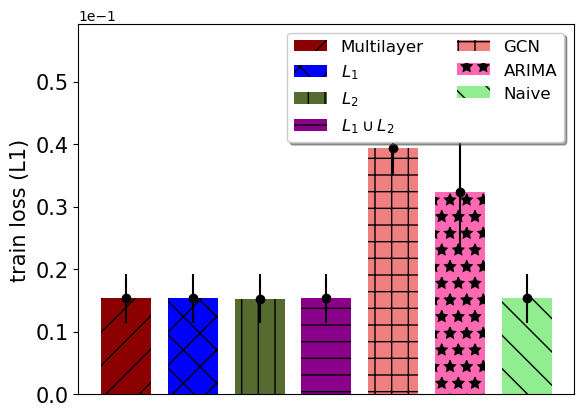

multi -> 0.013589569564182589
l1 -> 0.013607098594612921
l2 -> 0.01358552059837983
lboth -> 0.013588119113481817
gnn -> 0.04048994928598404
arima -> 0.02960744221263355
naive -> 0.013552813078394474


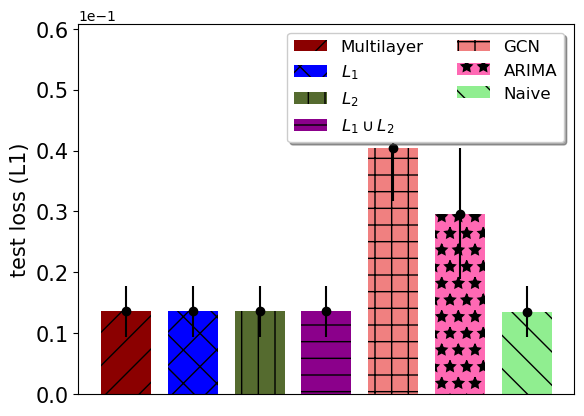

In [87]:
plot_loss(alg_results, 'train')
plot_loss(alg_results, 'test')